# Calculating fourier transform

We know that a fourier transformation of a signal give us a representation of that signal in a different space. This transformation can be seen as a fourier series of the input signal, in this form, we get for _real signals_ a series representatio of the form:

$$ f(t) = \frac{a_0}{2} + \sum_{n=1}^{\infty} [a_n cos(\omega_n t) + b_n sin(\omega_n t)]$$

Where the coeficientes are calculated through an integral which is called the Fourier Transform. This coeficiente can be interpreted as the results of a linear regression using as dependent variable($y$) the input signal and as independent variable(X) a fourier matrix splited into cosine and sine part.

$$ y = X \beta $$

Here we write $\beta$ as the vector of the coeficients, going from $\{a_0, a_1, ..., a_n, b_0, b_1, b_2, ...b_n\}$. $X$ will be a matrix where the i-column has $\{1, cos(\omega_1 t_i), cos(\omega_2 t_i), ..., cos(\omega_n t_i), 0, sin(\omega_1 t_i), ..., sin(\omega_n t_i)\}$, and thus, $y$ should be a vectoy that stores the input signal in every second that was captured $\{f(t_1), f(t_2), ..., f(t_n)\}$.

With this notation, we can obtain a fourier transform of a real signal by doing a linear regression while keep tracking of the coeficients, here the first $n$ coeficients are the real part of the fourier transform and the following coeficients are the imaginary part, the coeficient $a_0$ represent the 0 frequency component which doesn't have an imaginary component because of the sine ($b_0$ should not be used).

## Testing the method
Then we need to check if this methods works properly, this means, check that it calculates correctly the transform of the data. The method is purely based on sklear implementation of linear regression but here we use a custom definition decladed in mfilter.regressions

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import random
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from mfilter.regressions import * #here it is the regression
from mfilter.types import FrequencySamples, TimeSeries, FrequencySeries, TimesSamples

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# frequency grid
def f_grid(t, gamma=1, f_max=None):
    f_min = 1/t.duration
    df = f_min / gamma
    if f_max is None:
        f_max = 0.5 * t.average_fs
    return FrequencySamples(input_time=t, minimum_frequency=f_min, maximum_frequency=f_max,
                            samples_per_peak=gamma)

freq: 100


Text(0.5,1,'FrequencySeries Signal')

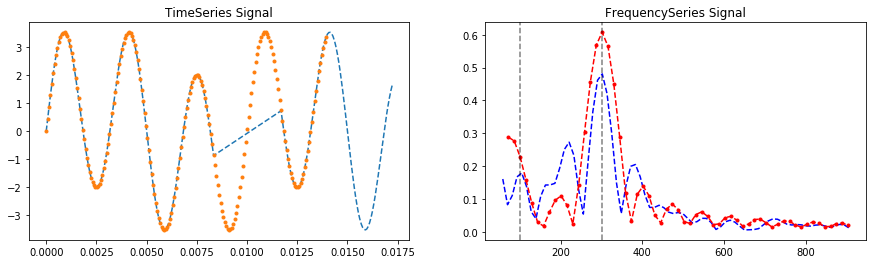

In [3]:
N = 200
basic_dt = 0.00007
times1 = TimesSamples(n=N, delta=basic_dt, struct="automix")
times2 = TimesSamples(n=N, delta=basic_dt, struct="normal")
times1 -= times1[0]
freq_sin = 100
print("freq:", freq_sin)
Factor = 3
data1 = np.sin(2 * np.pi * freq_sin * times1)
data1 += 3 * np.sin(2 * np.pi * freq_sin * Factor * times1)

data2 = np.sin(2 * np.pi * freq_sin * times2)
data2 += 3 * np.sin(2 * np.pi * freq_sin * Factor * times2)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(times1, data1, '--')
ax1.plot(times2, data2, '.')

f_max = 3*Factor*freq_sin
# f_max = None
gamma = 5
f1 = f_grid(times1, gamma=gamma, f_max=f_max)
f2 = f_grid(times2, gamma=gamma, f_max=f_max)

#define time series
T1 = TimeSeries(data1, times=times1)
T2 = TimeSeries(data2, times=times2)

# define regressor
reg = SGDRegression(alpha=10**(-4), max_iter=100)
reg.reset()
reg.create_dict(times1, f1)
F1 = T1.to_frequencyseries(reg=reg)
reg.reset()
reg.create_dict(times2, f2)
F2 = T2.to_frequencyseries(reg=reg)
ax2.plot(f1, np.abs(F1), 'b--',label=r"$f_{max}=f_s/2$, $\gamma=1$")
ax2.plot(f2, np.abs(F2), 'r.--', label=r"$f_{max}=f_s/2$, $\gamma=1$")
ax2.axvline(freq_sin, color="k", linestyle='--', alpha=0.5)
ax2.axvline(freq_sin*Factor, color="k", linestyle='--', alpha=0.5)
ax1.set_title("TimeSeries Signal")
ax2.set_title("FrequencySeries Signal")


Text(0.5,1,'FrequencySeries Signal')

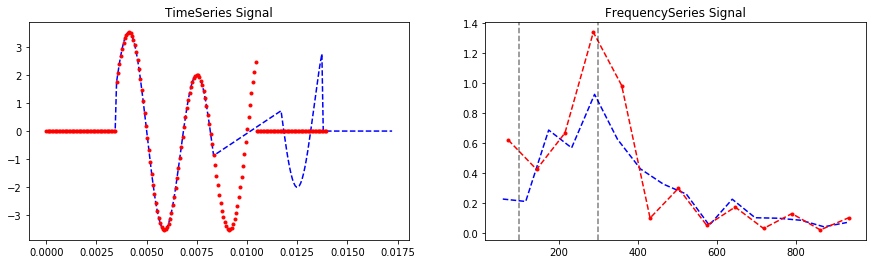

<Figure size 432x288 with 0 Axes>

In [5]:
init = N//4
end=(N//4)*3
data1[:init] = 0
data1[end:] = 0

data2[:init] = 0
data2[end:] = 0

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(times1, data1, 'b--')
ax1.plot(times2, data2, 'r.')

f_max = 3*Factor*freq_sin
# f_max = None
f1 = f_grid(times1, gamma=1, f_max=f_max)
f2 = f_grid(times2, gamma=1, f_max=f_max)

#define time series
T1 = TimeSeries(data1, times=times1)
T2 = TimeSeries(data2, times=times2)

# define regressor
reg = SGDRegression(alpha=10**(-4), max_iter=100)
reg.reset()
reg.create_dict(times1, f1)
F1 = T1.to_frequencyseries(reg=reg)

reg.reset()
reg.create_dict(times2, f2)
F2 = T2.to_frequencyseries(reg=reg)
plt.figure()
ax2.plot(f1, np.abs(F1), 'b--',label=r"$f_{max}=f_s/2$, $\gamma=1$")
ax2.plot(f2, np.abs(F2), 'r.--', label=r"$f_{max}=f_s/2$, $\gamma=1$")
ax2.axvline(freq_sin, color="k", linestyle='--', alpha=0.5)
ax2.axvline(freq_sin*Factor, color="k", linestyle='--', alpha=0.5)
ax1.set_title("TimeSeries Signal")
ax2.set_title("FrequencySeries Signal")


In [5]:
# # declared a test input data, here we are going to use two sines on a non-regular time grid.
# Factor = 3
# def input_signal(N, basic_dt, struct, seg, freq_sin, init):
#     t = TimesSamples(n=N, delta=basic_dt, struct=struct)
#     data = np.zeros(len(t))
#     data[init:init+seg] = np.sin(2 * np.pi * freq_sin * (t[init:init+seg]-t[init]))
#     data[init:init+seg] += 3 * np.sin(2 * np.pi * freq_sin * Factor * (t[init:init+seg]-t[init]))
#     return t, data
# N = 200
# basic_dt = 0.0001
# true_freq = 1 / (0.5 * N * basic_dt)
# times, data = input_signal(N, 0.0001, "automix", int(N/3), true_freq, N//5)
# times2, data2 = input_signal(N, times.duration / N, "regular", int(N/3), true_freq, N//5)
# times2 += times[0]
# plt.figure()
# plt.plot(times, data, '.')
# plt.figure()
# plt.plot(times2, data2, '.')
# limit1 = times.average_fs/2
# limit2 = times2.average_fs/2
# print("freqs: ", true_freq, true_freq*Factor)
# print("limit irregular:", limit1, ", and regular:", limit2)

In [6]:
# # geting the frequency grid, can be obtained manually or by using the code in the package.
# def f_grid(t, gamma=1):
#     f_min = 1/t.duration
#     df = f_min / gamma
#     f_max = 0.5 * t.average_fs
#     return np.linspace(f_min, f_max, int(round(f_max/df))), FrequencySamples(input_time=t,
#                                                                              minimum_frequency=f_min,
#                                                                              maximum_frequency=f_max, 
#                                                                              samples_per_peak=gamma)
# f_1, f1 = f_grid(times, gamma=1)
# f_2, f2 = f_grid(times2, gamma=1)
# #define time series
# T1 = TimeSeries(data, times=times)
# T2 = TimeSeries(data2, times=times2)
# # define regressor
# reg = SGDRegression(alpha=10**(-4), max_iter=100)
# reg.reset()
# reg.create_dict(times, f1)
# F1 = T1.to_frequencyseries(reg=reg)
# reg.reset()
# reg.create_dict(times, f2)
# F2 = T2.to_frequencyseries(reg=reg)
# plt.plot(f1, np.abs(F1), 'b',label=r"$f_{max}=f_s/2$, $\gamma=1$")
# plt.plot(f2, np.abs(F2), 'r', label=r"$f_{max}=f_s/2$, $\gamma=1$")
# plt.axvline(true_freq, color="k")
# plt.axvline(true_freq*Factor, color="k")